In [1]:
# load data
import numpy as np
train_file = np.load('data/train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('data/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)


train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed, Dropout

/Users/mehul/Documents/UCSD Classes/Deep Learning/AgroverseComp/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
import pickle

def save_model(model, filepath='lstm_single_step.pkl'):
    """Save model and scaler together in a pickle file"""
    model_json = model.to_json()
    model_weights = model.get_weights()
    data = {
        'model_json': model_json,
        'model_weights': model_weights,
    }
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    print(f"Model saved to {filepath}")

def load_model(filepath='lstm_single_step.pkl'):
    """Load model and scaler from pickle file"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    # Reconstruct model
    model = tf.keras.models.model_from_json(data['model_json'])
    model.set_weights(data['model_weights'])
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [62]:
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, TimeDistributed, Attention, Concatenate,
    RepeatVector
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def old_model(
    input_dim, output_dim, timesteps_in, timesteps_out,
    lstm_units=64, num_layers=1, loss_fn='mse', lr=0.001
):
    # --- Input and Learnable Feature Weighting ---
    encoder_inputs = Input(shape=(timesteps_in, input_dim))  # shape: (batch, Tobs, 6)
    weighted_inputs = TimeDistributed(Dense(input_dim, activation=None))(encoder_inputs)

    # --- Encoder ---
    x = weighted_inputs
    for _ in range(num_layers):
        x = LSTM(lstm_units, return_sequences=True)(x)
    encoder_outputs = x  # shape: (batch, Tobs, lstm_units)

    # --- Decoder ---
    decoder_input = RepeatVector(timesteps_out)(encoder_outputs[:, -1, :])
    decoder_outputs = decoder_input
    for _ in range(num_layers):
        decoder_outputs = LSTM(lstm_units, return_sequences=True)(decoder_outputs)

    # --- Attention ---
    # attention = Attention()([decoder_outputs, encoder_outputs])
    # x = Concatenate()([decoder_outputs, attention])

    # --- Dense Layers ---
    x = TimeDistributed(Dense(128, activation='relu'))(x)
    x = TimeDistributed(Dense(64, activation='relu'))(x)
    outputs = TimeDistributed(Dense(output_dim))(x)

    model = Model(encoder_inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=lr, clipnorm=.5), loss=loss_fn, metrics=['mae'])

    return model


In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [75]:
def create_single_step_model(input_dim, timesteps_in, lstm_units=256, num_layers=1, loss_fn='mse', lr=0.001):
    """
    Simplified model for single-step prediction.
    Input: (batch, timesteps, features)
    Output: (batch, 2) - single delta prediction
    """
    
    # Input
    inputs = Input(shape=(timesteps_in, input_dim))
    
    # LSTM layers
    x = inputs
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for all but last layer
        x = LSTM(lstm_units, return_sequences=return_sequences, dropout=0.1)(x)
    
    # Dense layers for final prediction
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2)(x)  # Predict single delta (x, y)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss=loss_fn, metrics=['mae'])
    
    return model

In [76]:
from keras.src.callbacks import LearningRateScheduler, EarlyStopping, Callback
from keras.src.optimizers import Adam
from keras import Model
import numpy as np


from tensorflow.keras.callbacks import Callback

class DynamicReduceLROnPlateau(Callback):
    def __init__(self, factor=0.5, patience=3, min_lr=1e-6, verbose=1):
        super().__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_val_loss = logs.get("val_loss")

        if current_val_loss is None:
            return  # can't do anything if val_loss isn't available

        if current_val_loss < self.best_val_loss - 1e-4:  # a small delta
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(self.model.optimizer.learning_rate.numpy())
                if old_lr > self.min_lr:
                    new_lr = max(old_lr * self.factor, self.min_lr)
                    self.model.optimizer.learning_rate.assign(new_lr)
                    if self.verbose:
                        print(f"\nEpoch {epoch+1}: val_loss did not improve. Reducing LR from {old_lr:.6f} to {new_lr:.6f}")
                    self.wait = 0  # reset after LR reduction






In [77]:
class LRThresholdCallback(Callback):
    def __init__(self, threshold=9e-5):
        super().__init__()
        self.threshold = threshold
        self.should_stop = False

    def on_epoch_end(self, epoch, logs=None):
        lr = float(self.model.optimizer.learning_rate.numpy())
        if lr < self.threshold:
            print(f"\nLearning rate {lr:.6f} < threshold {self.threshold}, moving to Phase 2.")
            self.model.stop_training = True


In [78]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class GradientMonitoringCallback(Callback):
    def __init__(self, clip_min=1e-4, clip_max=1e2, monitor_frequency=3):
        """
        Monitor gradient norms during training
        
        Args:
            clip_min: Minimum threshold for gradient norms
            clip_max: Maximum threshold for gradient norms  
            monitor_frequency: How often to check gradients (every N batches)
        """
        print(f"🔧 GradientMonitoringCallback initialized with clip_min={clip_min}, clip_max={clip_max}, monitor_freq={monitor_frequency}")
        self.clip_min = clip_min
        self.clip_max = clip_max
        self.monitor_frequency = monitor_frequency
        self.batch_count = 0
        self.total_calls = 0
        self.gradient_checks = 0
        self.fallback_calls = 0
        
    def on_train_begin(self, logs=None):
        print("🚀 GradientMonitoringCallback: Training started!")
        self.batch_count = 0
        self.total_calls = 0
        self.gradient_checks = 0
        self.fallback_calls = 0
        
    # def on_epoch_begin(self, epoch, logs=None):
    #     print(f"📍 GradientMonitoringCallback: Starting epoch {epoch + 1}")
        
    # def on_train_batch_begin(self, batch, logs=None):
    #     # Just to prove we're being called
    #     if batch % 50 == 0:  # Print every 50 batches to avoid spam
    #         print(f"⚡ GradientMonitoringCallback: Batch {batch} starting")
        
    def on_train_batch_end(self, batch, logs=None):
        self.batch_count += 1
        self.total_calls += 1
        
        # Print every time to show we're being called
        # if batch % 50 == 0:  # Print every 50 batches
            # print(f"📊 GradientMonitoringCallback: Batch {batch} ended (total calls: {self.total_calls})")
        
        # Only monitor every N batches to avoid performance overhead
        if self.batch_count % self.monitor_frequency != 0:
            return
            
        # print(f"🔍 GradientMonitoringCallback: Checking gradients at batch {batch} (check #{self.gradient_checks + 1})")
        
        # Get gradients from the optimizer's current state
        try:
            # Access the model's optimizer to get gradient information
            optimizer = self.model.optimizer
            print(f"   📋 Optimizer type: {type(optimizer).__name__}")
            
            # Get trainable variables
            trainable_vars = self.model.trainable_variables
            print(f"   📈 Number of trainable variables: {len(trainable_vars)}")
            
            if hasattr(optimizer, 'get_gradients'):
                print("   ✅ Optimizer has get_gradients method")
                # For some optimizers, we can access gradients directly
                grads = optimizer.get_gradients(self.model.total_loss, trainable_vars)
                print(f"   📊 Retrieved {len([g for g in grads if g is not None])} gradients")
            else:
                print("   ❌ Optimizer doesn't have get_gradients, using variable norms")
                # Alternative approach: check the current variable states
                grad_norms = []
                for i, var in enumerate(trainable_vars):
                    if var is not None:
                        var_norm = tf.norm(var)
                        grad_norms.append(var_norm)
                        if i < 3:  # Print first 3 for debugging
                            print(f"      Variable {i} norm: {float(var_norm.numpy()):.2e}")
                
                self._check_norms(grad_norms, "Variable")
                self.gradient_checks += 1
                return
                
            # Compute gradient norms
            grad_norms = []
            for i, grad in enumerate(grads):
                if grad is not None:
                    grad_norm = tf.norm(grad)
                    grad_norms.append(grad_norm)
                    if i < 3:  # Print first 3 for debugging
                        print(f"      Gradient {i} norm: {float(grad_norm.numpy()):.2e}")
                    
            print(f"   ✅ Computed {len(grad_norms)} gradient norms")
            self._check_norms(grad_norms, "Gradient")
            self.gradient_checks += 1
            
        except Exception as e:
            print(f"   ❌ Exception in gradient monitoring: {str(e)}")
            self.fallback_calls += 1
            # Fallback: just monitor the loss for signs of instability
            print('   🔄 Fallback: monitoring loss only')
            if logs:
                loss_value = logs.get('loss', 0)
                print(f"   📉 Current loss: {loss_value:.2e}")
                if np.isnan(loss_value) or np.isinf(loss_value):
                    print(f"   ⚠️  WARNING: Loss became {loss_value} at batch {batch}")
                elif loss_value > 1e6:
                    print(f"   ⚠️  WARNING: Very large loss {loss_value:.2e} at batch {batch}")
    
    def _check_norms(self, norms, norm_type="Gradient"):
        """Check if norms are within acceptable range"""
        print(f"   🔬 Checking {len(norms)} {norm_type.lower()} norms...")
        warnings = 0
        
        for idx, norm in enumerate(norms):
            try:
                norm_value = float(norm.numpy()) if hasattr(norm, 'numpy') else float(norm)
                
                if norm_value > self.clip_max:
                    print(f"   ⚠️  WARNING: {norm_type} norm {norm_value:.2e} is too large (layer {idx})")
                    warnings += 1
                elif norm_value < self.clip_min:
                    print(f"   ⚠️  WARNING: {norm_type} norm {norm_value:.2e} is too small (layer {idx})")
                    warnings += 1
                elif np.isnan(norm_value) or np.isinf(norm_value):
                    print(f"   ⚠️  WARNING: {norm_type} norm is {norm_value} (layer {idx})")
                    warnings += 1
                    
            except Exception as e:
                print(f"   ❌ Cannot convert norm to float for layer {idx}: {str(e)}")
                continue
                
        if warnings == 0:
            print(f"   ✅ All {norm_type.lower()} norms are within acceptable range")
        else:
            print(f"   ⚠️  Found {warnings} norm warnings")
    
    # def on_epoch_end(self, epoch, logs=None):
    #     """Print summary at end of each epoch"""
    #     print(f"📈 GradientMonitoringCallback: Epoch {epoch + 1} completed")
    #     print(f"   📊 Total batch calls: {self.total_calls}")
    #     print(f"   🔍 Gradient checks performed: {self.gradient_checks}")
    #     print(f"   🔄 Fallback calls: {self.fallback_calls}")
    #     
    #     if logs:
    #         loss = logs.get('loss', 0)
    #         val_loss = logs.get('val_loss', 0)
    #         print(f"   📉 Final epoch loss: {loss:.2e}")
    #         if val_loss:
    #             print(f"   📉 Final epoch val_loss: {val_loss:.2e}")
    #         
    #         if np.isnan(loss) or np.isinf(loss):
    #             print(f"   ⚠️  WARNING: Training loss became unstable: {loss}")
    #         if val_loss and (np.isnan(val_loss) or np.isinf(val_loss)):
    #             print(f"   ⚠️  WARNING: Validation loss became unstable: {val_loss}")
        
    def on_train_end(self, logs=None):
        print("🏁 GradientMonitoringCallback: Training completed!")
        print(f"   📊 Final stats - Total calls: {self.total_calls}, Gradient checks: {self.gradient_checks}, Fallbacks: {self.fallback_calls}")
        
        if self.total_calls == 0:
            print("   ❌ ERROR: Callback was never called! Check if it's properly added to callbacks list.")
        elif self.gradient_checks == 0 and self.fallback_calls == 0:
            print("   ⚠️  WARNING: No gradient monitoring was performed. Check monitor_frequency setting.")
        else:
            print("   ✅ Gradient monitoring completed successfully!")

In [79]:
from tensorflow.keras.callbacks import Callback

class SaveBestModelCallback(Callback):
    def __init__(self, save_path='best_model.keras', monitor='val_loss'):
        super().__init__()
        self.best = float('inf')
        self.monitor = monitor
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None and current < self.best:
            self.best = current
            print(f"\nNew best {self.monitor}: {current:.6f}. Saving model...")
            save_model(self.model, 'lstm_single_step.pkl')


In [80]:
from tensorflow.keras.callbacks import LearningRateScheduler

def exponential_decay_schedule(epoch, lr):
    decay_rate = 0.5
    decay_steps = 10
    if epoch % decay_steps == 0 and epoch:
        print('Learning rate update:', lr * decay_rate)
        return lr * decay_rate
    return lr

In [81]:
def train_model(train_data, batch_size=32, validation_split=0.2, Tobs=50, epochs=50, epochs2=10, lr1=0.001, lr2=0.00001):
    n_scenarios, n_agents, T, D = train_data.shape  # Expecting (10000, 50, 110, 6)
    assert D == 6, "Expected 6 features per timestep (position, velocity, heading, object_type)."

    X_train_raw, y_train_deltas = [], []
    
    
    pruned_fully_padded = 0
    pruned_invalid_positions = 0
    pruned_too_many_zeros = 0
    valid_samples_count = 0  # To count how many valid samples are being used
    
    for i in range(n_scenarios):
        for j in range(n_agents):
            agent_data = train_data[i, j, :, :]  # shape (110, 6)
    
            if np.all(agent_data == 0):
                pruned_fully_padded += 1
                continue  # skip fully padded agent
    
            # Create sliding window samples for single-step prediction
            for t in range(Tobs, T - 1):  # From timestep 50 to 108 (inclusive)
                # Input: previous Tobs timesteps (e.g., timesteps 0-49, 1-50, 2-51, etc.)
                input_window = agent_data[t-Tobs:t, :]  # shape (50, 6)
                
                # Target: delta from current position to next position
                current_pos = agent_data[t, :2]      # shape (2,)
                next_pos = agent_data[t+1, :2]       # shape (2,)
                delta = next_pos - current_pos       # shape (2,)
    
                # Skip only if current or next positions are invalid, or if too many zeros in window
                if np.all(current_pos == 0) or np.all(next_pos == 0):
                    pruned_invalid_positions += 1
                    continue
                
                # Allow some zeros in the window, but not too many (e.g., less than 80% valid)
                valid_positions = ~np.all(input_window[:, :2] == 0, axis=1)
                if np.sum(valid_positions) < 0.6 * Tobs:  # At least 60% of timesteps must be valid
                    pruned_too_many_zeros += 1
                    continue
    
                X_train_raw.append(input_window)     # shape (50, 6)
                y_train_deltas.append(delta)         # shape (2,)
                valid_samples_count += 1  # Count valid samples
    
    # Final print statements to summarize pruning
    print(f"Total fully padded agents pruned: {pruned_fully_padded}")
    print(f"Total invalid positions pruned (either current or next position was all zeros): {pruned_invalid_positions}")
    print(f"Total samples pruned due to too many zeros in the window: {pruned_too_many_zeros}")
    print(f"Total valid samples used for training: {valid_samples_count}\n")
    
    # Convert to numpy arrays for training
    X_train = np.array(X_train_raw)           # shape (N, 50, 6)
    y_train = np.array(y_train_deltas)        # shape (N, 2)

    print(f"Training on {X_train.shape[0]} valid timestep sequences.")
    print(f"Input shape: {X_train.shape}, Output shape: {y_train.shape}")

    # Add debugging info
    print(f"Delta stats: mean={y_train.mean(axis=0)}, std={y_train.std(axis=0)}")
    print(f"Delta range: min={y_train.min(axis=0)}, max={y_train.max(axis=0)}")

    # --- Normalize ---
    X_mean = X_train.mean(axis=(0, 1), keepdims=True)  # shape: (1, 1, 6)
    X_std = X_train.std(axis=(0, 1), keepdims=True) + 1e-8

    y_mean = y_train.mean(axis=0, keepdims=True)  # shape: (1, 2)
    y_std = y_train.std(axis=0, keepdims=True) + 1e-8

    X_train = (X_train - X_mean) / X_std
    y_train = (y_train - y_mean) / y_std

    # --- Model (simplified for single-step prediction) ---
    model = create_single_step_model(
        input_dim=X_train.shape[-1],
        timesteps_in=Tobs,
        loss_fn='mse',
        lr=lr1
    )
    
    lr_scheduler_callback = LearningRateScheduler(exponential_decay_schedule, verbose=1)
    
    gradient_monitoring_callback = GradientMonitoringCallback(clip_min=1e-4, clip_max=1e2)
    
    save_best_callback = SaveBestModelCallback(save_path='lstm_single_step', monitor='val_loss')

    phase1_callbacks = [
        DynamicReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5),
        # lr_scheduler_callback,
        save_best_callback,
        EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss'),
        LRThresholdCallback(threshold=9e-8)
    ]

    print("\n--- Phase 1: Training ---")
    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=phase1_callbacks,
        verbose=1
    )

    print("\n--- Phase 2: Fine-tuning ---")
    model.compile(optimizer=Adam(lr2), loss='mse', metrics=['mae'])
    phase2_callbacks = [
        LearningRateScheduler(exponential_decay_schedule),
        EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
        save_best_callback,
        LRThresholdCallback(threshold=9e-8)

    ]
    model.fit(
        X_train, y_train,
        epochs=epochs2,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=phase2_callbacks,
        verbose=1
    )

    return model, X_mean, X_std, y_mean, y_std

In [44]:
def reconstruct_absolute_positions(pred_deltas, last_observed_positions):
    """
    Reconstruct absolute predicted positions by adding deltas to the last observed position.

    Args:
        pred_deltas: np.ndarray of shape (N, Tpred, 2)
        last_observed_positions: np.ndarray of shape (N, 2)

    Returns:
        np.ndarray of shape (N, Tpred, 2)
    """
    return last_observed_positions[:, None, :] + np.cumsum(pred_deltas, axis=1)


def forecast_positions(scenario_data, Tobs, Tpred, model, X_mean=None, X_std=None, y_mean=None, y_std=None):
    """
    Use single-step LSTM model to forecast future deltas iteratively and reconstruct absolute positions.
    
    This function performs autoregressive prediction: uses the model to predict one step ahead,
    then incorporates that prediction into the input window for the next prediction.

    Args:
        scenario_data (numpy.ndarray): Shape (agents, time_steps, dimensions)
        Tobs (int): Number of observed time steps (window size for model input)
        Tpred (int): Number of future time steps to predict
        model (Model): Trained single-step LSTM model that predicts one normalized delta
        X_mean, X_std: Normalization stats for input (optional)
        y_mean, y_std: Normalization stats for output (optional)

    Returns:
        numpy.ndarray: Predicted absolute positions of shape (agents, Tpred, 2)
    """
    agents, total_timesteps, features = scenario_data.shape
    predicted_positions = np.zeros((agents, Tpred, 2))

    for agent_idx in range(agents):
        # Get initial observation window
        agent_data = scenario_data[agent_idx, :Tobs, :].copy()  # shape (Tobs, 6)

        # Skip if fully padded
        if np.all(agent_data == 0):
            continue

        # Initialize the sliding window with observed data
        current_window = agent_data.copy()  # shape (Tobs, 6)
        
        # Store predicted deltas for this agent
        pred_deltas = np.zeros((Tpred, 2))
        
        # Iteratively predict each future timestep
        for step in range(Tpred):
            # Prepare input for model (current sliding window)
            X_pred = np.expand_dims(current_window, axis=0)  # shape (1, Tobs, 6)
            
            # Normalize input if stats are provided
            if X_mean is not None and X_std is not None:
                X_pred = (X_pred - X_mean) / X_std

            # Predict next delta (single step)
            pred_delta = model.predict(X_pred, verbose=0)  # shape (1, 2)
            
            # Denormalize delta if stats are provided
            if y_mean is not None and y_std is not None:
                pred_delta = pred_delta * y_std + y_mean
                
            pred_deltas[step] = pred_delta[0]  # Store the predicted delta

            # Calculate next absolute position
            current_pos = current_window[-1, :2]  # Last position in window
            next_pos = current_pos + pred_delta[0]  # Add predicted delta
            
            # Create next timestep features
            # Copy other features from the last timestep (velocity, heading, object_type)
            next_timestep = current_window[-1].copy()  # shape (6,)
            next_timestep[:2] = next_pos  # Update position
            
            # Update sliding window: remove oldest, add newest
            current_window = np.roll(current_window, -1, axis=0)  # Shift left
            current_window[-1] = next_timestep  # Add new timestep at the end

        # Reconstruct absolute positions from deltas
        last_observed_pos = agent_data[-1, :2]  # Last observed position
        abs_positions = reconstruct_absolute_positions(
            pred_deltas=np.expand_dims(pred_deltas, axis=0),  # shape (1, Tpred, 2)
            last_observed_positions=np.expand_dims(last_observed_pos, axis=0)  # shape (1, 2)
        )[0]  # shape (Tpred, 2)

        predicted_positions[agent_idx] = abs_positions

    return predicted_positions

funky prediciton

In [45]:
import numpy as np

def generate_augmented_scenario_data(scenario_data, Tobs, Tpred, verbose=False):
    """
    Filters agent trajectories to keep only those similar to ego in velocity profile and type,
    and then generates sliding window samples for those agents.

    Args:
        scenario_data (np.ndarray): (num_agents, time_steps, 6)
        Tobs (int): Observation window size
        Tpred (int): Prediction horizon (should be 1 for delta-based prediction)
        verbose (bool): Whether to print pruning stats

    Returns:
        X_filtered (np.ndarray): (N, Tobs, 6)
        y_filtered (np.ndarray): (N, 2)
    """
    num_agents, T, D = scenario_data.shape
    assert D == 6, "Expected 6 dimensions per timestep"

    ego_traj = scenario_data[0]
    ego_type = int(ego_traj[0, 5])
    ego_vel = ego_traj[:Tobs, 2:4]  # velocity_x, velocity_y

    # Ego guaranteed valid positions for all Tobs steps
    if np.any(np.all(ego_traj[:Tobs, :2] == 0, axis=1)):
        raise ValueError("Ego agent does not have valid positions for all observed steps.")

    ego_flat_vel = ego_vel.flatten()  # shape (Tobs*2,)

    X_filtered = []
    y_filtered = []

    pruned_fully_padded = 0
    pruned_type_mismatch = 0
    pruned_velocity_mismatch = 0
    pruned_invalid_positions = 0
    accepted_samples = 0

    for agent_idx in range(1, num_agents):  # skip ego
        traj = scenario_data[agent_idx]

        if np.all(traj == 0):
            pruned_fully_padded += 1
            continue

        agent_type = int(traj[0, 5])
        if agent_type != ego_type:
            pruned_type_mismatch += 1
            continue

        # Require agent to have valid positions for all Tobs steps
        if np.any(np.all(traj[:Tobs, :2] == 0, axis=1)):
            pruned_velocity_mismatch += 1
            continue

        agent_obs_vel = traj[:Tobs, 2:4]
        agent_flat_vel = agent_obs_vel.flatten()

        # Compute cosine similarity between velocity profiles
        dot = np.dot(ego_flat_vel, agent_flat_vel)
        norm = np.linalg.norm(ego_flat_vel) * np.linalg.norm(agent_flat_vel)
        similarity = dot / norm if norm > 0 else -1

        if similarity < 0.7:
            pruned_velocity_mismatch += 1
            continue

        # Passed similarity filter: generate sliding window samples
        for t in range(Tobs, T - Tpred):
            input_window = traj[t - Tobs:t, :]  # shape (Tobs, 6)
            current_pos = traj[t, :2]
            next_pos = traj[t + Tpred, :2]
            delta = next_pos - current_pos

            # Skip if current or next position is zero (invalid)
            if np.all(current_pos == 0) or np.all(next_pos == 0):
                pruned_invalid_positions += 1
                continue

            X_filtered.append(input_window)
            y_filtered.append(delta)
            accepted_samples += 1

    if verbose:
        print(f"Total agents: {num_agents}")
        print(f"Accepted samples: {accepted_samples}")
        print(f"Pruned fully padded agents: {pruned_fully_padded}")
        print(f"Pruned type mismatches: {pruned_type_mismatch}")
        print(f"Pruned due to velocity mismatch: {pruned_velocity_mismatch}")
        print(f"Pruned invalid positions: {pruned_invalid_positions}")

    return np.array(X_filtered), np.array(y_filtered)


In [46]:
def finetune_forecast_positions(scenario_data, Tobs, Tpred, model, 
                                 X_mean=None, X_std=None, y_mean=None, y_std=None, 
                                 epochs=3, lr=1e-4, max_repeats=5, verbose=False):
    """
    Fine-tune model on relevant agents from a scenario, then forecast future positions.

    Args:
        scenario_data (np.ndarray): Array (agents, time_steps, 6)
        Tobs (int): Number of observed time steps
        Tpred (int): Number of prediction time steps
        model (tf.keras.Model): LSTM model to be fine-tuned
        X_mean, X_std, y_mean, y_std: Normalization statistics (optional)
        epochs (int): Number of fine-tuning epochs
        lr (float): Learning rate for fine-tuning
        max_repeats (int): Max weight (duplication count) for close agents

    Returns:
        np.ndarray: Predicted positions (agents, Tpred, 2)
    """
    import copy
    from tensorflow.keras.optimizers import Adam

    agents, total_steps, _ = scenario_data.shape
    assert total_steps >= Tobs + Tpred, "Not enough time steps for observation + prediction"

    # Generate fine-tuning data with importance scaling
    X_finetune, y_finetune = generate_augmented_scenario_data(scenario_data, Tobs, Tpred, verbose=verbose)

    if len(X_finetune) == 0:
        print("No valid agents found for fine-tuning.")
        return np.zeros((agents, Tpred, 2))

    # Normalize input/output if stats provided
    if X_mean is not None and X_std is not None:
        X_finetune = (X_finetune - X_mean) / X_std
    if y_mean is not None and y_std is not None:
        y_finetune = (y_finetune - y_mean) / y_std
        
    # print(X_finetune.shape)  # (N, 50, 6)
    # print(y_finetune.shape)  # (N, 60, 2)

    # Clone model to preserve original weights
    model_finetune = copy.deepcopy(model)
    model_finetune.compile(optimizer=Adam(learning_rate=lr, clipnorm=0.5), loss='mse')
    
    gradient_monitoring_callback = GradientMonitoringCallback(clip_min=1e-4, clip_max=1e2)
    # Train on augmented samples
    model_finetune.fit(
        X_finetune,
        y_finetune,
        epochs=epochs,
        verbose=1,
        # callbacks=[gradient_monitoring_callback]
    )

    # Predict for each agent in the scenario
    predicted_positions = np.zeros((agents, Tpred, 2))

    for agent_idx in range(agents):
        agent_obs = scenario_data[agent_idx, :Tobs, :]

        if np.any(np.all(agent_obs == 0, axis=1)):
            continue

        X_pred = np.expand_dims(agent_obs, axis=0)

        if X_mean is not None and X_std is not None:
            X_pred = (X_pred - X_mean) / X_std

        pred_deltas = model_finetune.predict(X_pred, verbose=0)

        if y_mean is not None and y_std is not None:
            pred_deltas = pred_deltas * y_std + y_mean

        last_pos = agent_obs[Tobs - 1, :2]
        abs_positions = reconstruct_absolute_positions(
            pred_deltas=pred_deltas,
            last_observed_positions=np.expand_dims(last_pos, axis=0)
        )[0]

        predicted_positions[agent_idx] = abs_positions

    return predicted_positions

In [47]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def make_gif(data_matrix1, data_matrix2, name='comparison'):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation

    cmap1 = plt.cm.get_cmap('viridis', 50)
    cmap2 = plt.cm.get_cmap('plasma', 50)

    assert data_matrix1.shape[1] == data_matrix2.shape[1], "Both matrices must have same number of timesteps"
    timesteps = data_matrix1.shape[1]

    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    ax1, ax2 = axes

    def update(frame):
        for ax in axes:
            ax.clear()

        for i in range(data_matrix1.shape[0]):
            for (data_matrix, ax, cmap) in [(data_matrix1, ax1, cmap1), (data_matrix2, ax2, cmap2)]:
                x = data_matrix[i, frame, 0]
                y = data_matrix[i, frame, 1]
                if x != 0 and y != 0:
                    xs = data_matrix[i, :frame+1, 0]
                    ys = data_matrix[i, :frame+1, 1]
                    mask = (xs != 0) & (ys != 0)
                    xs = xs[mask]
                    ys = ys[mask]
                    if len(xs) > 0 and len(ys) > 0:
                        color = cmap(i)
                        ax.plot(xs, ys, alpha=0.9, color=color)
                        ax.scatter(x, y, s=80, color=color)

        # Plot ego vehicle (index 0) on both
        ax1.plot(data_matrix1[0, :frame, 0], data_matrix1[0, :frame, 1], color='tab:orange', label='Ego Vehicle')
        ax1.scatter(data_matrix1[0, frame, 0], data_matrix1[0, frame, 1], s=80, color='tab:orange')
        ax1.set_title('Prediction')

        ax2.plot(data_matrix2[0, :frame, 0], data_matrix2[0, :frame, 1], color='tab:orange', label='Ego Vehicle')
        ax2.scatter(data_matrix2[0, frame, 0], data_matrix2[0, frame, 1], s=80, color='tab:orange')
        ax2.set_title('Actual')

        for ax, data_matrix in zip(axes, [data_matrix1, data_matrix2]):
            ax.set_xlim(data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].min() - 10,
                        data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].max() + 10)
            ax.set_ylim(data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].min() - 10,
                        data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].max() + 10)
            ax.legend()
            ax.set_xlabel('X')
            ax.set_ylabel('Y')

        # Compute MSE over non-zero entries up to current frame
        mask = (data_matrix2[:, :frame+1, :] != 0) & (data_matrix1[:, :frame+1, :] != 0)
        mse = np.mean((data_matrix1[:, :frame+1, :][mask] - data_matrix2[:, :frame+1, :][mask]) ** 2)

        fig.suptitle(f"Timestep {frame} - MSE: {mse:.4f}", fontsize=16)
        return ax1.collections + ax1.lines + ax2.collections + ax2.lines

    anim = animation.FuncAnimation(fig, update, frames=list(range(0, timesteps, 3)), interval=100, blit=True)
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()


In [48]:
def plot_mae_by_timestep(y_true, y_pred):
    """
    Visualize MAE across timesteps in the prediction horizon.
    
    Args:
        y_true (np.ndarray): shape (N, Tpred, 2)
        y_pred (np.ndarray): shape (N, Tpred, 2)
    """
    mae_per_timestep = np.mean(np.abs(y_true - y_pred), axis=(0, 2))  # shape (Tpred,)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(mae_per_timestep, label='MAE per Timestep')
    plt.xlabel('Timestep')
    plt.ylabel('MAE (meters)')
    plt.title('Mean Absolute Error Over Prediction Horizon')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [82]:
# first check that the model can overfit on small data
# shuffled_train_data = train_data.copy()
# np.random.shuffle(shuffled_train_data)  # shuffles in-place along axis 0 (scenarios)

model, X_mean, X_std, y_mean, y_std  = train_model(train_data[:30], batch_size=30, validation_split=0.2, epochs=100, epochs2=100, lr1 = 0.001, lr2=0.00001)

Total fully padded agents pruned: 370
Total invalid positions pruned (either current or next position was all zeros): 27691
Total samples pruned due to too many zeros in the window: 9461
Total valid samples used for training: 29518

Training on 29518 valid timestep sequences.
Input shape: (29518, 50, 6), Output shape: (29518, 2)
Delta stats: mean=[-0.01675608 -0.0146366 ], std=[0.43118823 0.24764302]
Delta range: min=[-1.90392655 -1.53115254], max=[2.13883475 1.51240904]
🔧 GradientMonitoringCallback initialized with clip_min=0.0001, clip_max=100.0, monitor_freq=3

--- Phase 1: Training ---
Epoch 1/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1692 - mae: 0.2247
New best val_loss: 0.176827. Saving model...
Model saved to lstm_single_step.pkl
788/788 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.1692 - mae: 0.2247 - val_loss: 0.1768 - val_mae: 0.2468
Epoch 2/100
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2110 - mae: 0.2834
New best val_loss: 0.162232. Saving model...
Mo

In [83]:
# save_model(model, "general_single_step.pkl")

In [89]:
# visualize prediction

# model = load_model()

# Parameters
Tobs = 50
Tpred = 60

data = train_data[3000]

# Select a test scenario (can use any valid index)
test_scenario = data.copy()  # shape (agents, time_steps, features)

# Forecast future positions
predicted_positions = forecast_positions(test_scenario, Tobs, Tpred, model, X_mean, X_std, y_mean, y_std)

# Create combined matrix of past observed + predicted for ego agent (agent 0)
ego_past = test_scenario[0, :Tobs, :2]               # shape (Tobs, 2)
ego_future = predicted_positions[0]                  # shape (Tpred, 2)
ego_full = np.concatenate([ego_past, ego_future], axis=0)  # shape (Tobs + Tpred, 2)

# Create updated scenario with predicted ego and original others
updated_scenario = test_scenario.copy()
updated_scenario[0, :Tobs+Tpred, :2] = ego_full  # Replace ego trajectory

# print(updated_scenario[0])

# Visualize
make_gif(updated_scenario, data, name='lstm_single_step')


/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_31200/3735350324.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = plt.cm.get_cmap('viridis', 50)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_31200/3735350324.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = plt.cm.get_cmap('plasma', 50)


Total agents: 50
Accepted samples: 0
Pruned fully padded agents: 3
Pruned type mismatches: 0
Pruned due to velocity mismatch: 45
Pruned invalid positions: 0
No valid agents found for fine-tuning.


/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_31200/3735350324.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = plt.cm.get_cmap('viridis', 50)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_31200/3735350324.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = plt.cm.get_cmap('plasma', 50)


KeyboardInterrupt: 

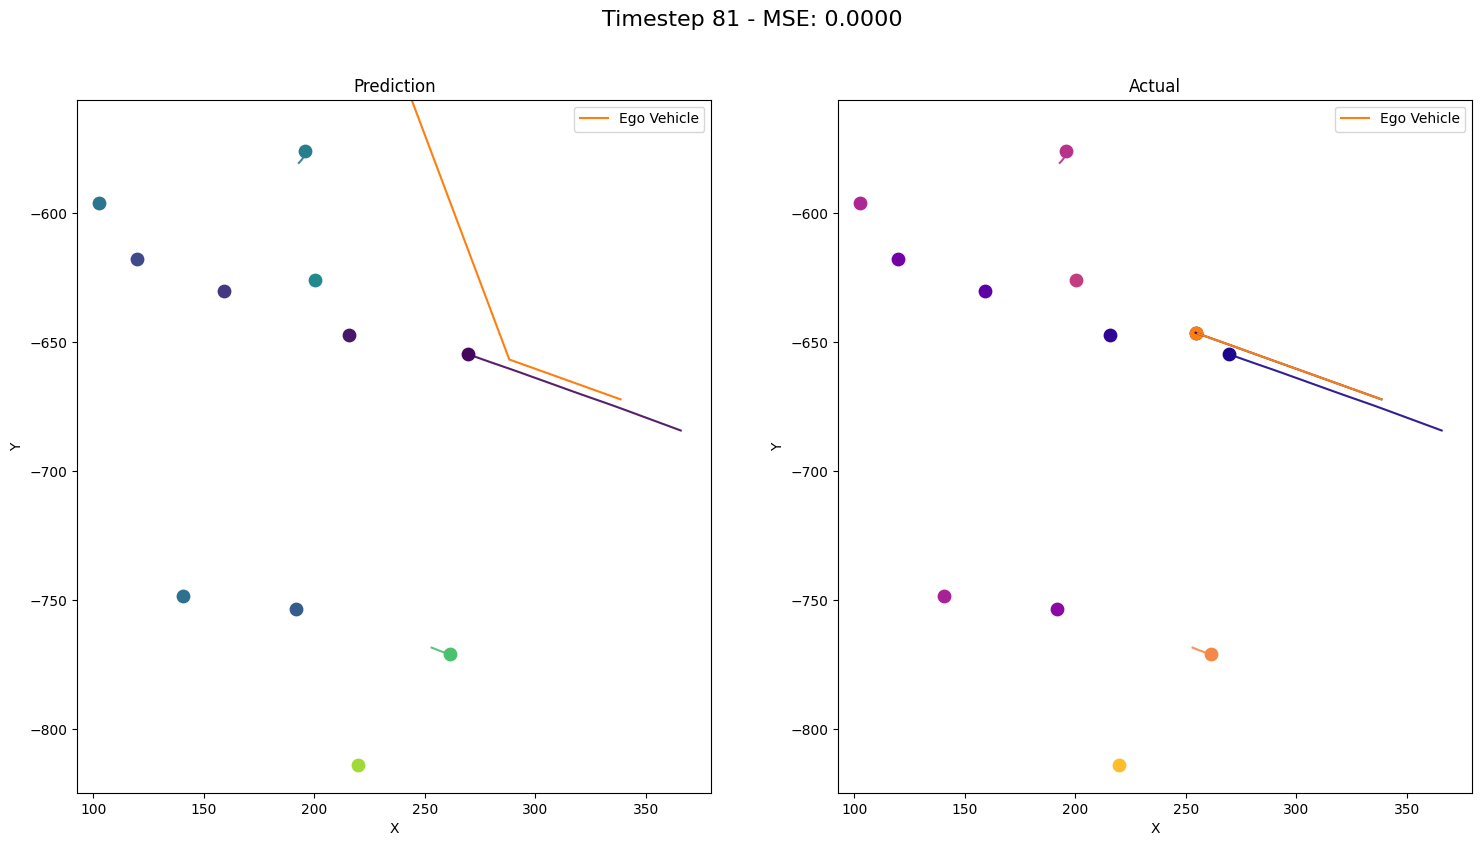

In [72]:
# visualize fine-tunded prediction

# model = load_model()

# Parameters
Tobs = 50
Tpred = 60

data = train_data[0]

# Select a test scenario (can use any valid index)
test_scenario = data.copy()  # shape (agents, time_steps, features)

# Forecast future positions
predicted_positions = finetune_forecast_positions(test_scenario, Tobs, Tpred, model, X_mean, X_std, y_mean, y_std, verbose=True)

# Create combined matrix of past observed + predicted for ego agent (agent 0)
ego_past = test_scenario[0, :Tobs, :2]               # shape (Tobs, 2)
ego_future = predicted_positions[0]                  # shape (Tpred, 2)
ego_full = np.concatenate([ego_past, ego_future], axis=0)  # shape (Tobs + Tpred, 2)

# Create updated scenario with predicted ego and original others
updated_scenario = test_scenario.copy()
updated_scenario[0, :Tobs+Tpred, :2] = ego_full  # Replace ego trajectory

# print(updated_scenario[0])

# Visualize
make_gif(updated_scenario, data, name='lstm_single_step')


In [ ]:
# Train the model -> to beat val of 0.0711
model, X_mean, X_std, y_mean, y_std = train_model(train_data)

# Save the model 
save_model(model)

In [86]:
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluate_mse(train_data, model, forecast_fn, Tobs=50, Tpred=60, 
                 X_mean=None, X_std=None, y_mean=None, y_std=None):
    """
    Evaluate MSE of a forecast function on ego agent across scenarios.

    Args:
        train_data (np.ndarray): Shape (N, agents, timesteps, features)
        model (tf.keras.Model): Trained single-step model
        forecast_fn (callable): Function to call for forecasting. Must match:
            (scenario_data, Tobs, Tpred, model, X_mean, X_std, y_mean, y_std) -> np.ndarray
        Tobs (int): Number of observed steps
        Tpred (int): Number of predicted steps
        X_mean, X_std, y_mean, y_std (optional): Normalization statistics

    Returns:
        float: Mean squared error across valid scenarios
    """
    N = train_data.shape[0]
    mse_list = []
    valid_scenarios = 0
    
    print(f"Evaluating {N} scenarios...")
    report_interval = max(1, N // 10)

    for i in range(N):
        if i % report_interval == 0 or i == N - 1:
            print(f"Processing scenario {i+1}/{N} ({(i+1)/N*100:.1f}%)")
        
        scenario_data = train_data[i]  # shape (agents, timesteps, 6)
        ego_agent_data = scenario_data[0]  # shape (timesteps, 6)
        ground_truth = ego_agent_data[Tobs:Tobs + Tpred, :2]

        if np.all(ground_truth == 0):
            continue

        valid_scenarios += 1

        predicted_positions = forecast_fn(
            ego_agent_data[np.newaxis, :, :],  # (1, timesteps, 6)
            Tobs, Tpred, model,
            X_mean=X_mean, X_std=X_std, y_mean=y_mean, y_std=y_std
        )

        mse = mean_squared_error(ground_truth, predicted_positions[0])
        mse_list.append(mse)

        if i % report_interval == 0:
            print(f"  Current scenario {i} MSE: {mse:.4f}")

    if mse_list:
        overall_mse = np.mean(mse_list)
        print(f"\nEvaluation complete: {valid_scenarios} valid scenarios")
        print(f"Mean Squared Error (MSE): {overall_mse:.4f}")
        print(f"Min MSE: {np.min(mse_list):.4f}, Max MSE: {np.max(mse_list):.4f}")
        return overall_mse
    else:
        print("No valid scenarios for evaluation.")
        return None

In [87]:
# Evaluate on training data
evaluate_mse(train_data[3000:3030], model, forecast_fn=forecast_positions)

Evaluating 30 scenarios...
Processing scenario 1/30 (3.3%)
  Current scenario 0 MSE: 5361.8938
Processing scenario 4/30 (13.3%)
  Current scenario 3 MSE: 2907.5031
Processing scenario 7/30 (23.3%)
  Current scenario 6 MSE: 5737.7192
Processing scenario 10/30 (33.3%)
  Current scenario 9 MSE: 3346.7940
Processing scenario 13/30 (43.3%)
  Current scenario 12 MSE: 3678.9222
Processing scenario 16/30 (53.3%)
  Current scenario 15 MSE: 12.3063
Processing scenario 19/30 (63.3%)
  Current scenario 18 MSE: 1043.1046
Processing scenario 22/30 (73.3%)
  Current scenario 21 MSE: 4337.2805
Processing scenario 25/30 (83.3%)
  Current scenario 24 MSE: 3588.6713
Processing scenario 28/30 (93.3%)
  Current scenario 27 MSE: 3550.3187
Processing scenario 30/30 (100.0%)

Evaluation complete: 30 valid scenarios
Mean Squared Error (MSE): 3320.9765
Min MSE: 12.3063, Max MSE: 8035.7212


3320.976507999308

In [ ]:
import pandas as pd
import numpy as np

def generate_submission(data, output_csv, model, forecast_fn, 
                        Tobs=50, Tpred=60,
                        X_mean=None, X_std=None, y_mean=None, y_std=None):
    """
    Generates a submission CSV file with predicted (x, y) positions for the ego agent.

    Args:
        data (np.ndarray): Test data of shape (num_scenarios, agents, timesteps, features).
        output_csv (str): Output CSV file path.
        model (tf.keras.Model): Trained prediction model.
        forecast_fn (callable): Forecast function with signature:
            (scenario_data, Tobs, Tpred, model, X_mean, X_std, y_mean, y_std) -> np.ndarray
        Tobs (int): Number of observed time steps.
        Tpred (int): Number of predicted time steps.
        X_mean, X_std, y_mean, y_std (optional): Normalization statistics.
    """

    predictions = []

    print(f"Generating predictions for {data.shape[0]} scenarios...")

    for i in range(data.shape[0]):
        scenario_data = data[i]            # Shape: (agents, timesteps, 6)
        ego_agent_data = scenario_data[0]  # Shape: (timesteps, 6)

        predicted_positions = forecast_fn(
            ego_agent_data[np.newaxis, :, :], Tobs, Tpred, model,
            X_mean=X_mean, X_std=X_std, y_mean=y_mean, y_std=y_std
        )  # Shape: (1, Tpred, 2)

        predictions.extend(predicted_positions[0])  # Append shape: (Tpred, 2)

    submission_df = pd.DataFrame(predictions, columns=["x", "y"])
    submission_df.index.name = 'index'  # Match required format
    submission_df.to_csv(output_csv)

    print(f"Submission file '{output_csv}' saved with shape {submission_df.shape}")


In [ ]:
generate_submission(
    data=test_data,
    output_csv='lstm_submission.csv',
    model=model,
    forecast_fn=forecast_positions,  # or finetune_forecast_positions
    Tobs=50,
    Tpred=60,
    X_mean=X_mean,
    X_std=X_std,
    y_mean=y_mean,
    y_std=y_std
)